<a href="https://colab.research.google.com/github/Arrheniuss/Anomaly_Detection_ML/blob/main/Anomaly_detection_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Wczytanie zbioru danych

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, classification_report
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
# Funkcja do obliczenia błędu rekonstrukcji
def reconstruction_error(original, reconstructed):
    return np.mean(np.square(original - reconstructed), axis=1)

In [ ]:
# Wczytanie zbioru danych z pliku csv.gz

df = pd.read_csv('KDD_Cup_1999.csv.gz', compression='gzip')

# 2. Eksploracyjna analiza danych

In [ ]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [ ]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'outcome'],
      dtype='object')

In [ ]:
# Rozkład wartosci 'outcome'
print(df['outcome'].value_counts())

outcome
smurf              280790
neptune            107201
normal              97278
back                 2203
satan                1589
ipsweep              1247
portsweep            1040
warezclient          1020
teardrop              979
pod                   264
nmap                  231
guess_passwd           53
buffer_overflow        30
land                   21
warezmaster            20
imap                   12
rootkit                10
loadmodule              9
ftp_write               8
multihop                7
phf                     4
perl                    3
spy                     2
Name: count, dtype: int64


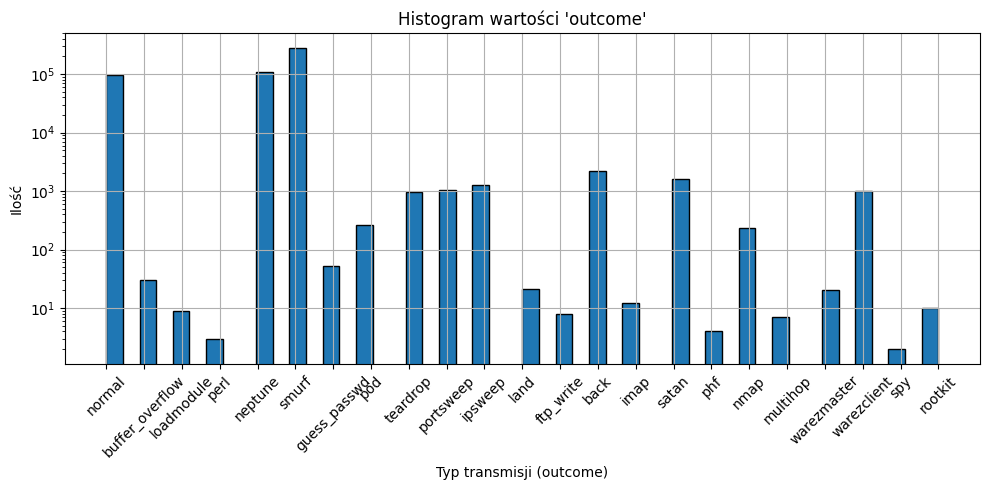

In [ ]:
# Rozkład dla 'outcome'
plt.figure(figsize=(10, 5))
df['outcome'].hist(bins=50, edgecolor='black')
plt.title("Histogram wartości 'outcome'")
plt.xlabel("Typ transmisji (outcome)")
plt.ylabel("Ilość")
plt.yscale('log')  # Zastosowanie skali logarytmicznej na osi Y
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

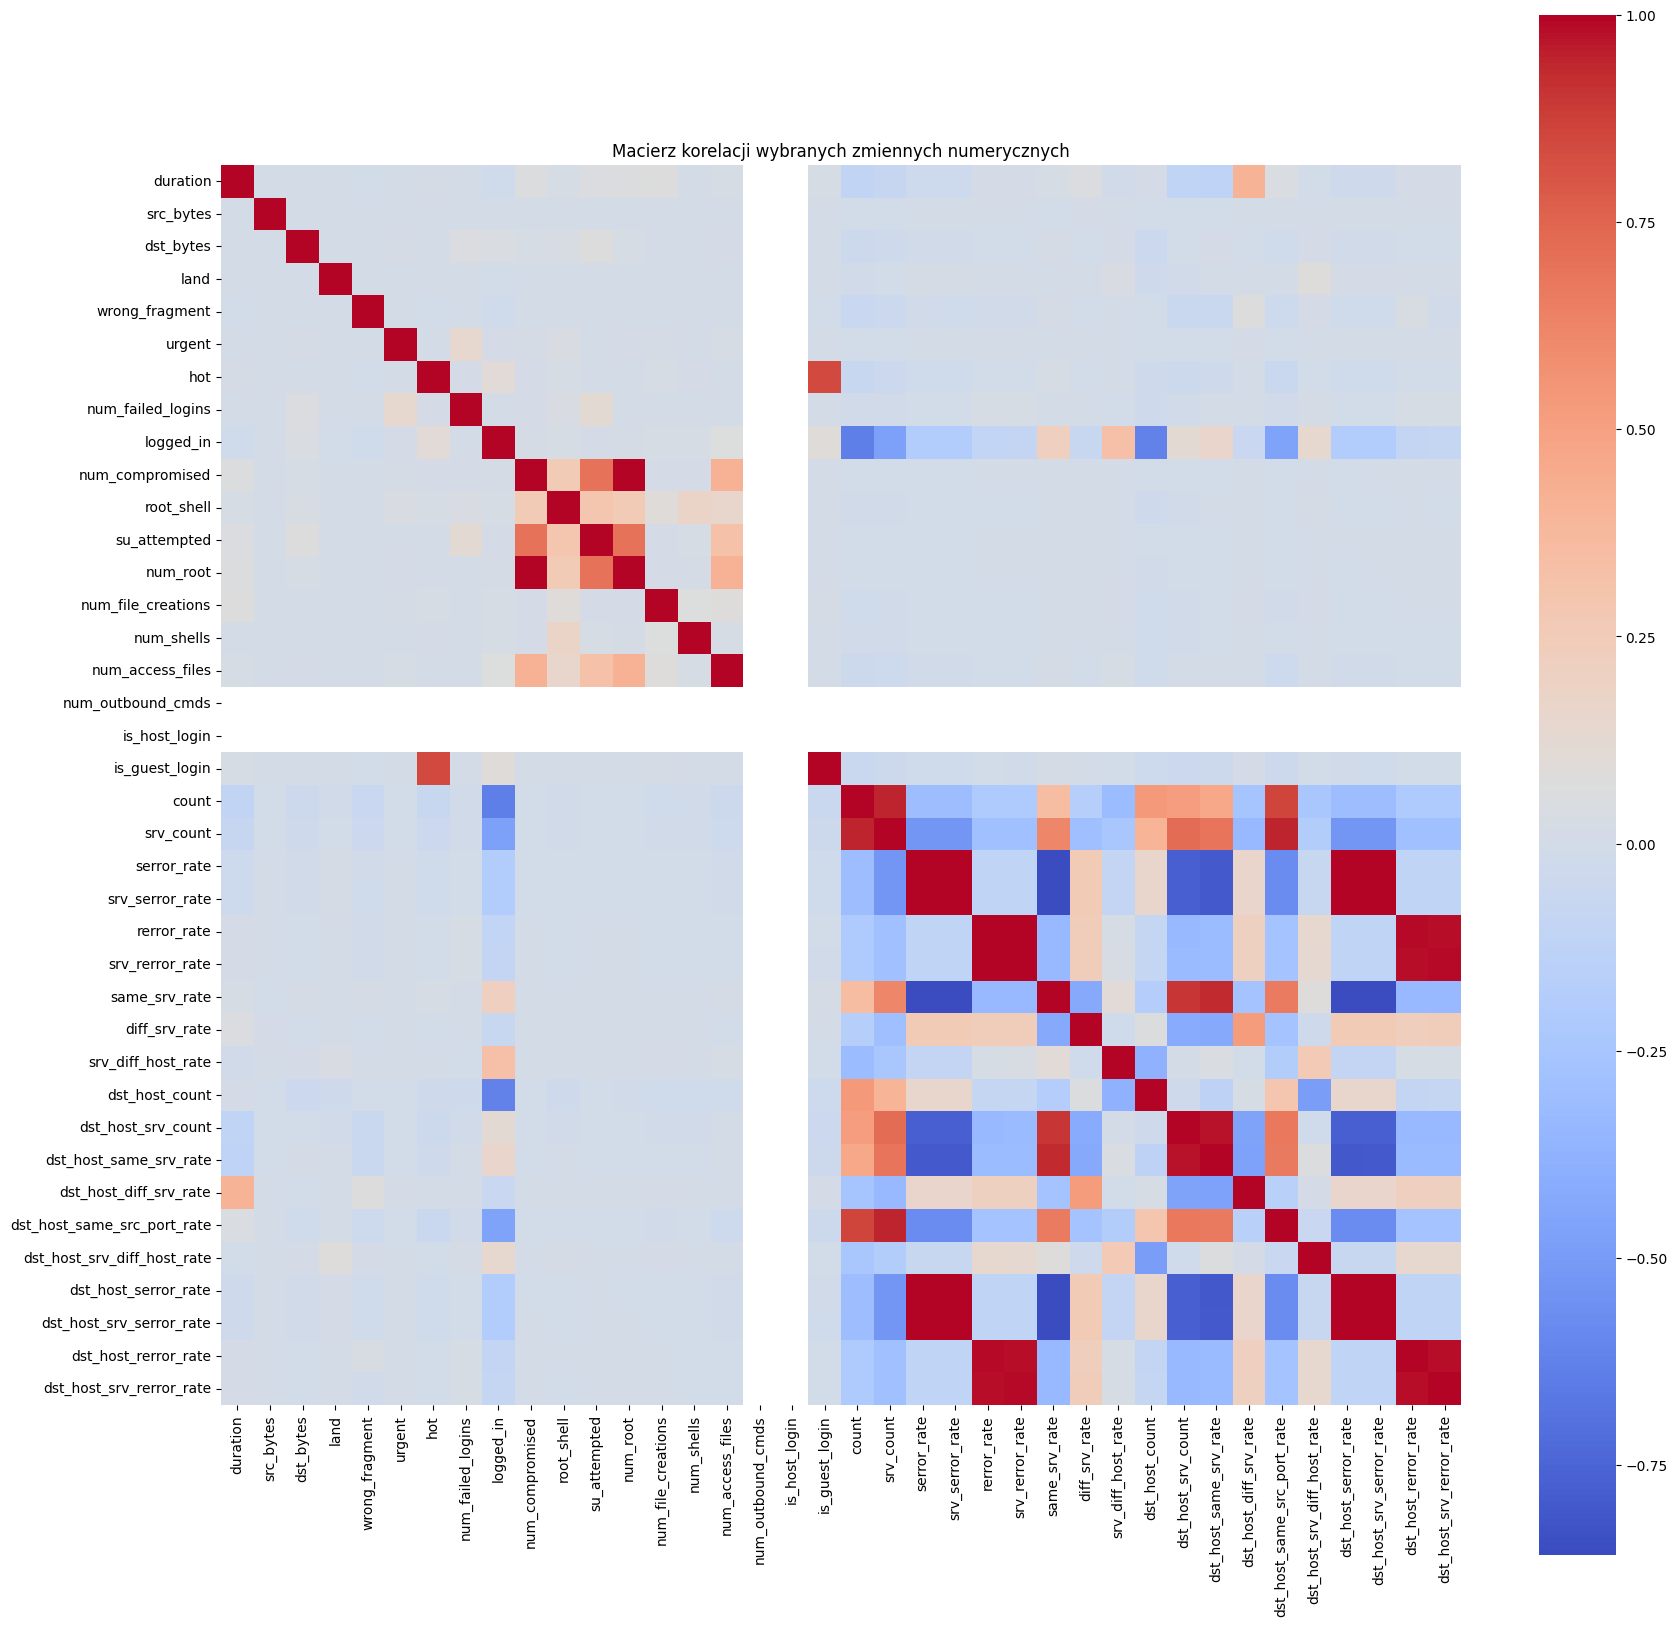

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title("Macierz korelacji wybranych zmiennych numerycznych")
plt.show()

In [ ]:
print((df == 0).sum())

duration                       481671
protocol_type                       0
service                             0
flag                                0
src_bytes                      115342
dst_bytes                      408258
land                           493999
wrong_fragment                 492783
urgent                         494017
hot                            490829
num_failed_logins              493958
logged_in                      420784
num_compromised                491797
root_shell                     493966
su_attempted                   494009
num_root                       493436
num_file_creations             493756
num_shells                     493970
num_access_files               493567
num_outbound_cmds              494021
is_host_login                  494021
is_guest_login                 493336
count                               2
srv_count                           2
serror_rate                    404787
srv_serror_rate                405686
rerror_rate 

In [ ]:
print(df.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

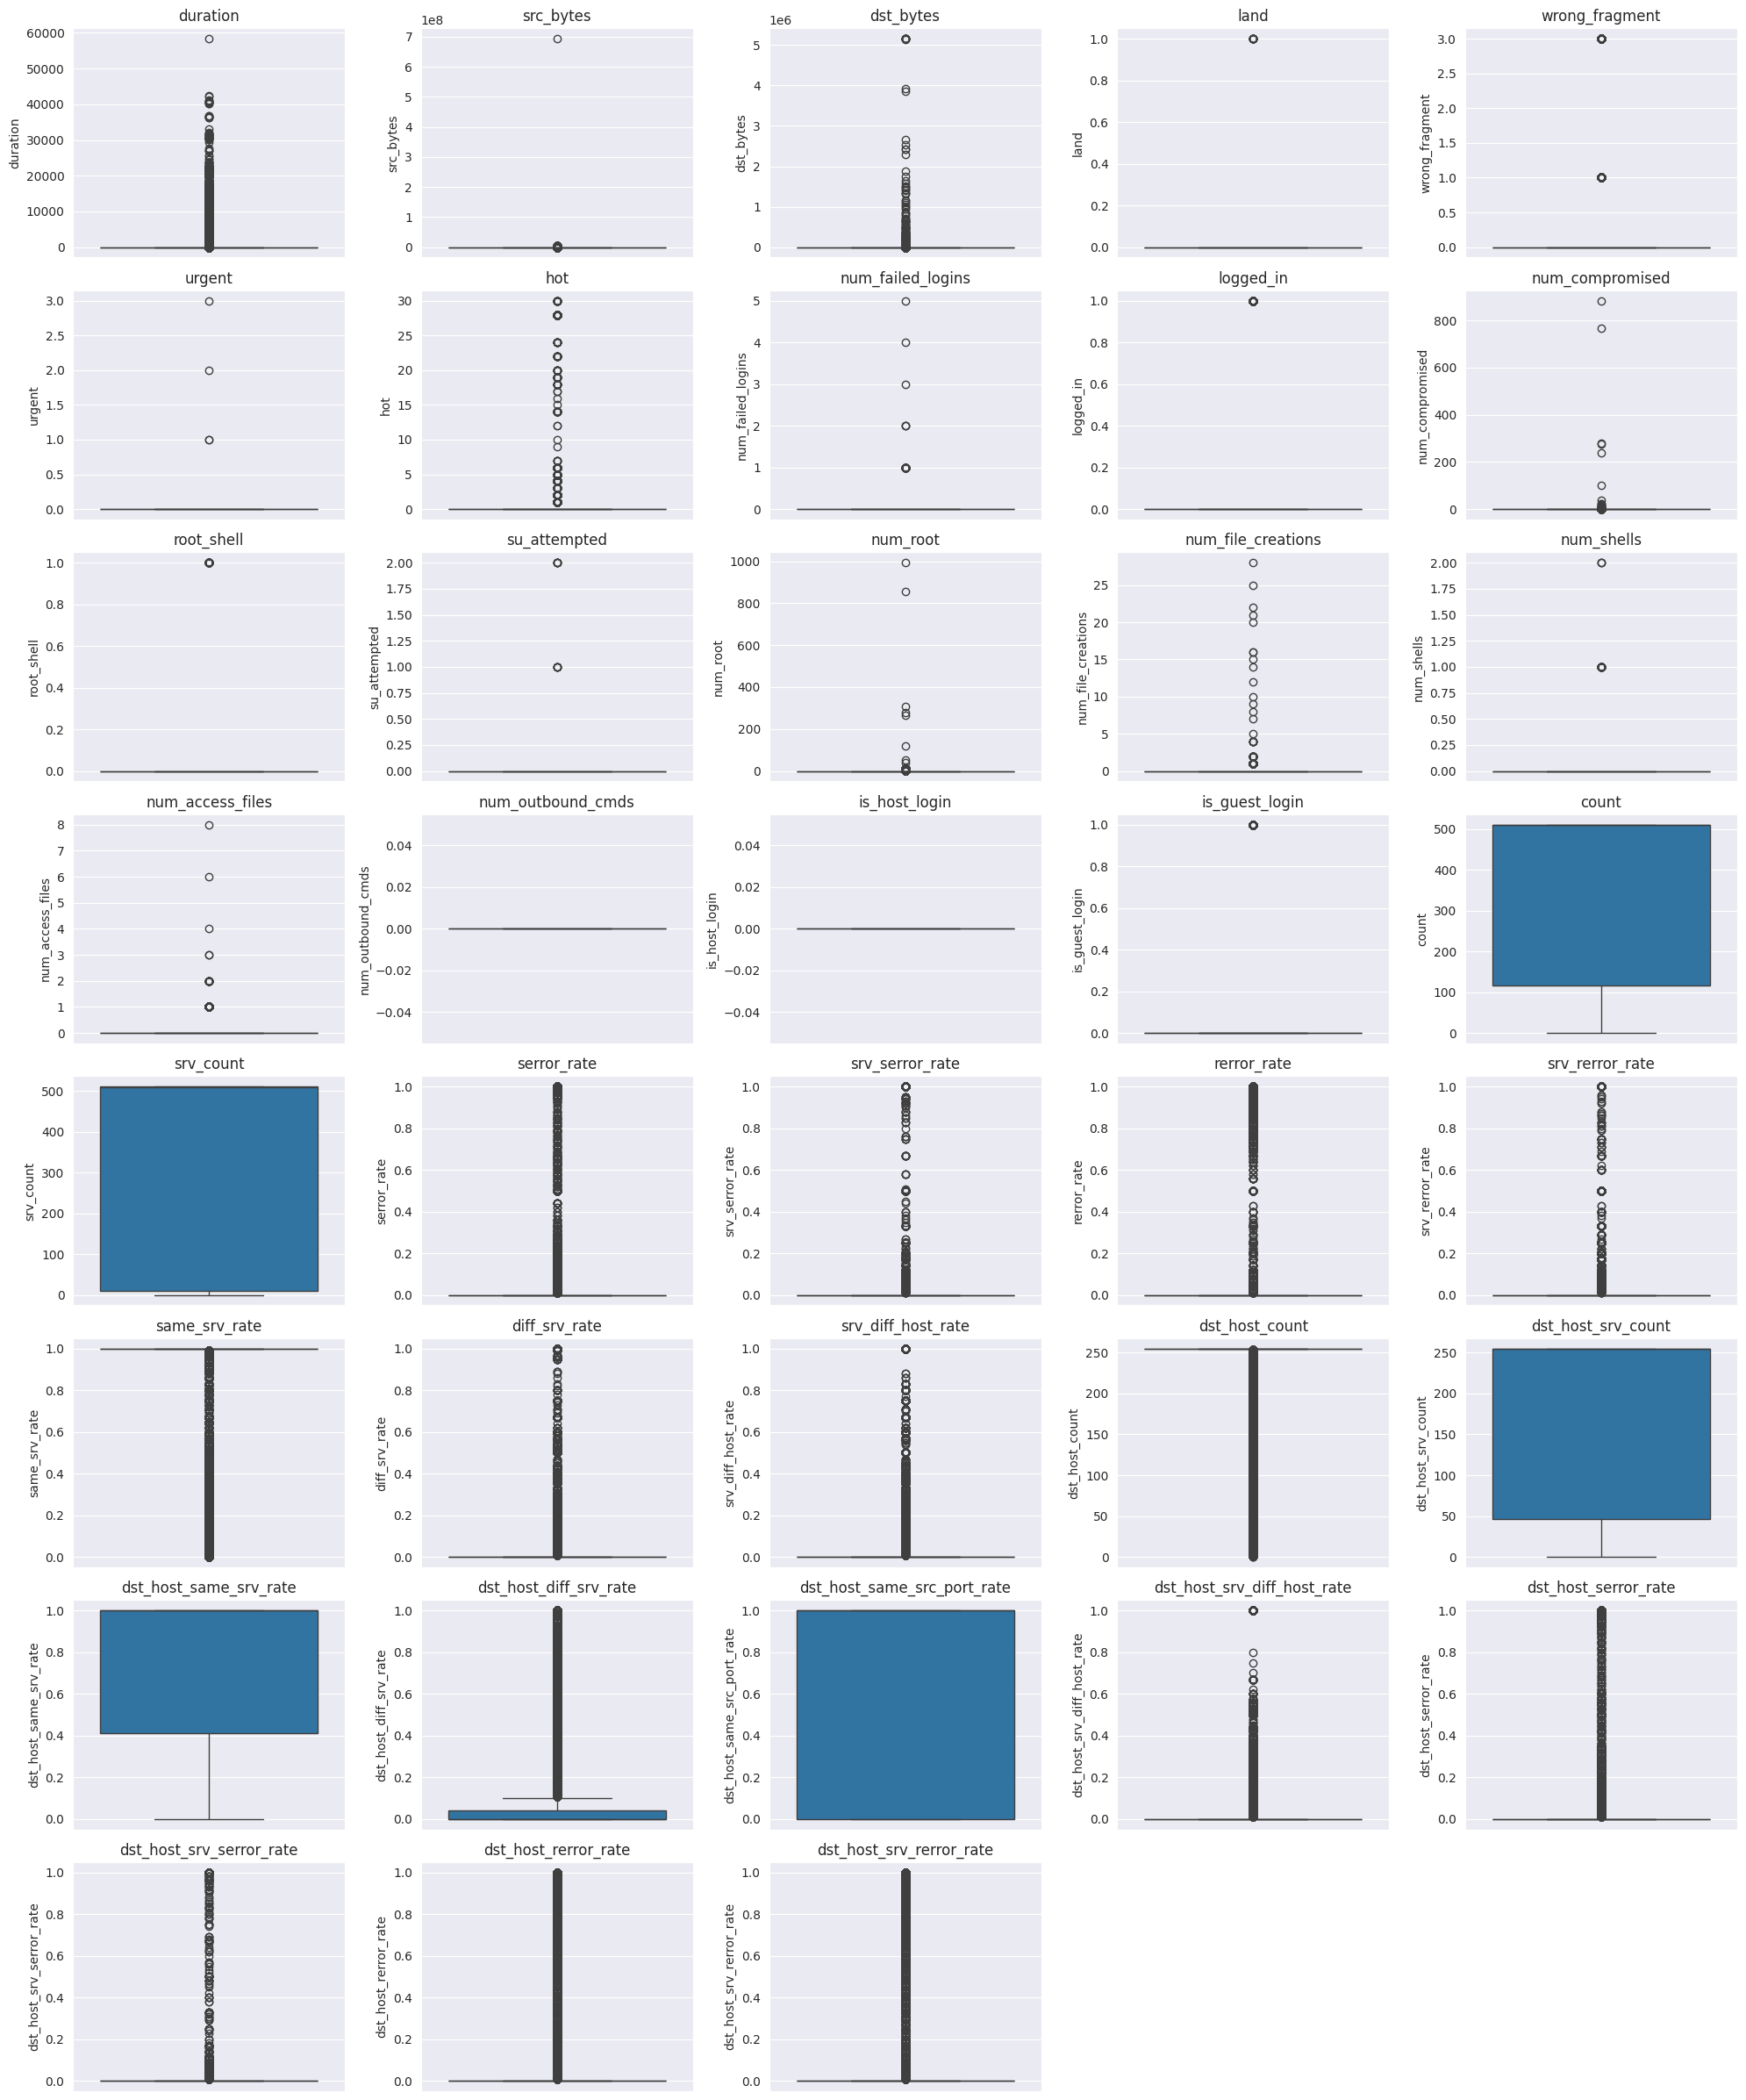

In [ ]:
# Tworzenie wykresów pudełkowych
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

sns.set_style("darkgrid")
plt.figure(figsize=(20, 30))
for i, column in enumerate(numeric_columns):
    plt.subplot(10, 5, i + 1)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()


# 3. Preprocessing, podział na zbiór treningowy i testowy

In [ ]:
# Progowanie zmiennych numerycznych
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[numeric_columns])
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_columns)

# Progowanie na podstawie mediany
numeric_binarized = (numeric_scaled_df >= np.median(numeric_scaled_df, axis=0)).astype(int)

# Kodowanie zmiennych kategorycznych
categorical_columns = ['protocol_type', 'service', 'flag']
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(df[categorical_columns])

# Tworzenie ramki danych dla zakodowanych zmiennych kategorycznych
encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Łączenie danych binarnych numerycznych i kategorycznych
df_prep = pd.concat([pd.DataFrame(numeric_binarized, columns=numeric_columns).reset_index(drop=True),
                            encoded_df.reset_index(drop=True)], axis=1)

In [ ]:
# Dodajemy zmienną outcome do przetworzonego zbioru, aby ułatwić podział
df_prep['outcome'] = df['outcome']

# Podział na zbiór treningowy i testowy (80/20)
df_train, df_test = train_test_split(df_prep, test_size=0.2, random_state=42, stratify=df_prep['outcome'])

# Wydzielenie podzbiorów normalnych i anomalii na podstawie wartości outcome
df_train_normal = df_train[df_train['outcome'] == 'normal'].drop(columns=['outcome'])
df_train_anom = df_train[df_train['outcome'] != 'normal'].drop(columns=['outcome'])

df_test_normal = df_test[df_test['outcome'] == 'normal'].drop(columns=['outcome'])
df_test_anom = df_test[df_test['outcome'] != 'normal'].drop(columns=['outcome'])

# Informacje o podziałach danych
train_normal_size = len(df_train_normal)
train_anom_size = len(df_train_anom)
test_normal_size = len(df_test_normal)
test_anom_size = len(df_test_anom)

print("Rozmiary zbiorów:")
print(f"Zbiór treningowy - normalne: {train_normal_size}, anomalie: {train_anom_size}")
print(f"Zbiór testowy - normalne: {test_normal_size}, anomalie: {test_anom_size}")

Rozmiary zbiorów:
Zbiór treningowy - normalne: 77822, anomalie: 317394
Zbiór testowy - normalne: 19456, anomalie: 79349


# 4. Budowa modelu

In [ ]:
# Rozmiar wejścia odpowiada liczbie cech w danych
input_dim = df_train_normal.shape[1]

# Definicja enkodera
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(8, activation='relu')(encoder)

# Definicja dekodera
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

# Kompilacja modelu autoenkodera
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 118)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          15,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 118)                 │          15,222 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,950 (195.12 KB)

 Trainable params: 49,950 (195.12 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Kompilacja autoenkodera
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['mse', 'mae'])

In [ ]:
# Konwersja danych na tablice NumPy
X_train_normal = df_train_normal.values
X_test_normal = df_test_normal.values

# 5. Trening modelu i wizualizacja przebiegu

In [ ]:
# Definicja callbacka do zatrzymania w razie przetrenowania
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Trenowanie modelu
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_normal, X_test_normal),
    callbacks=[es]
)

Epoch 1/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0676 - mae: 0.0452 - mse: 0.0212 - val_loss: 0.0140 - val_mae: 0.0088 - val_mse: 0.0041
Epoch 2/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0129 - mae: 0.0080 - mse: 0.0037 - val_loss: 0.0058 - val_mae: 0.0035 - val_mse: 0.0016
Epoch 3/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0068 - mae: 0.0040 - mse: 0.0019 - val_loss: 0.0039 - val_mae: 0.0023 - val_mse: 0.0010
Epoch 4/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0050 - mae: 0.0029 - mse: 0.0014 - val_loss: 0.0030 - val_mae: 0.0017 - val_mse: 7.6225e-04
Epoch 5/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0042 - mae: 0.0024 - mse: 0.0011 - val_loss: 0.0025 - val_mae: 0.0015 - val_mse: 6.4613e-04
Epoch 6/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0036 - mae: 0.0020 - mse: 9.5016e-04 - val_loss: 0.0021 - val_mae: 0.0012 - val_mse: 5.4425e-04
Epoch 7/100
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.

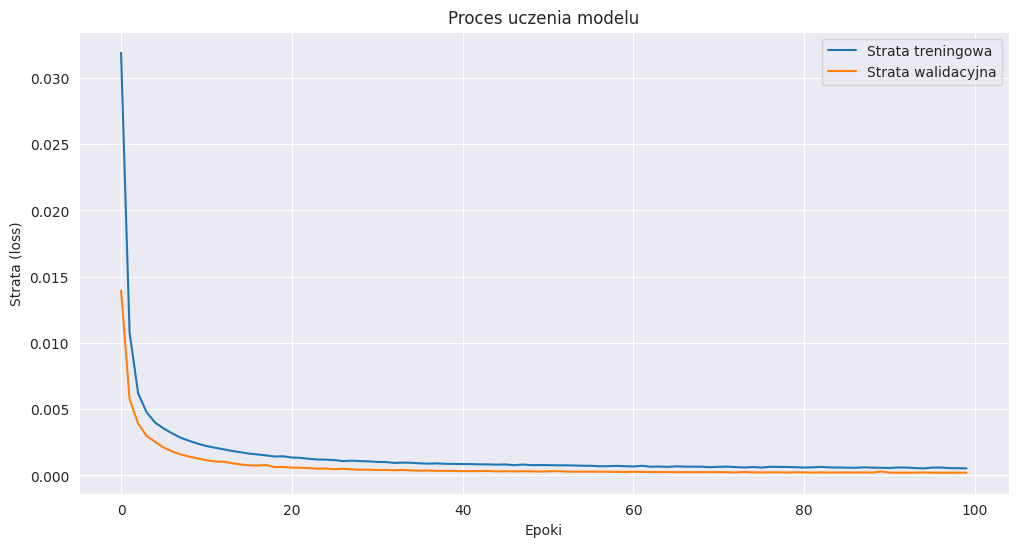

In [ ]:
# Wykres funkcji straty
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Proces uczenia modelu')
plt.xlabel('Epoki')
plt.ylabel('Strata (loss)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Ocena jakości wytrenowanego modelu

In [ ]:
# Obliczenie błędów rekonstrukcji
reconstructed_train_normal = autoencoder.predict(X_train_normal)
reconstructed_test_normal = autoencoder.predict(X_test_normal)
reconstructed_test_anom = autoencoder.predict(df_test_anom.values)

error_train_normal = reconstruction_error(X_train_normal, reconstructed_train_normal)
error_test_normal = reconstruction_error(X_test_normal, reconstructed_test_normal)
error_test_anom = reconstruction_error(df_test_anom.values, reconstructed_test_anom)

2432/2432 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


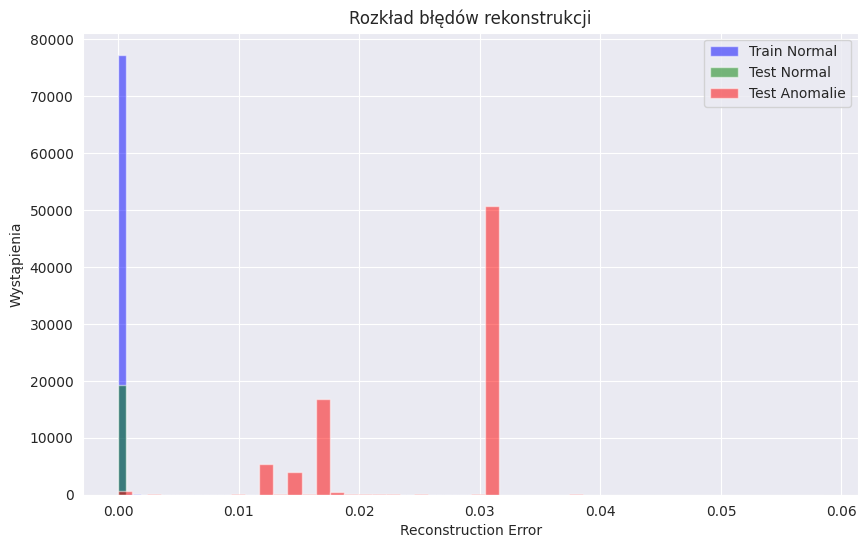

In [ ]:
# Wizualizacja histogramów błędów rekonstrukcji
plt.figure(figsize=(10, 6))
plt.hist(error_train_normal, bins=50, alpha=0.5, label='Train Normal', color='blue')
plt.hist(error_test_normal, bins=50, alpha=0.5, label='Test Normal', color='green')
plt.hist(error_test_anom, bins=50, alpha=0.5, label='Test Anomalie', color='red')
plt.xlabel('Reconstruction Error')
plt.ylabel('Wystąpienia')
plt.legend()
plt.title('Rozkład błędów rekonstrukcji')
plt.show()

In [ ]:
# Wybór progu odcięcia
threshold = np.percentile(error_train_normal, 98)

# Klasyfikacja na podstawie błędu rekonstrukcji
y_pred_test_normal = (error_test_normal >= threshold).astype(int)
y_pred_test_anom = (error_test_anom >= threshold).astype(int)

# Przygotowanie prawdziwych etykiet i przewidywań
y_true = np.concatenate([np.zeros_like(error_test_normal), np.ones_like(error_test_anom)])
y_pred = np.concatenate([y_pred_test_normal, y_pred_test_anom])

In [ ]:
# Macierz pomyłek
conf_matrix = confusion_matrix(y_true, y_pred)
print("Macierz pomyłek:")
print(conf_matrix)

# Krzywa ROC i AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

Macierz pomyłek:
[[19052   404]
 [  257 79092]]


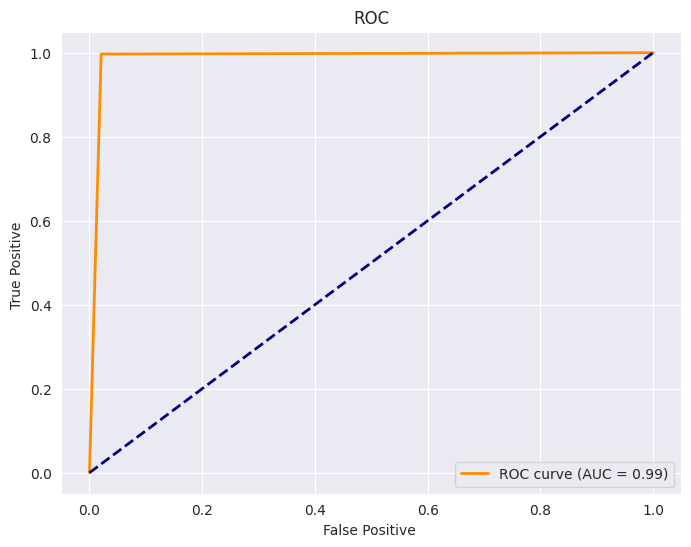

In [ ]:
# Krzywa ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive ')
plt.ylabel('True Positive ')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# 7. Wnioski

1. **Struktura modelu i przygotowanie danych**


*   Model: Autoenkoder o następującej architekturze:
  *   Enkoder: trzy warstwy gęste (128, 64, 32, 8 neuronów) z Dropout (0.2)
  *   Dekoder: lustrzane odwzorowanie enkodera
*   Funkcja straty: Binarna entropia krzyżowa
*   Optymalizator: RMSprop, który stabilizuje proces uczenia się na danych ciągłych



*   Przygotowanie danych:

  *   Zdecydowano nie usuwać wartości odstających, ponieważ mogą one reprezentować potencjalne anomalie sieciowe (np. ataki DoS), które są kluczowe do prawidłowego wykrycia przez autoenkoder. Usunięcie tych wartości mogłoby skutkować mniejszą skutecznością wykrywania nietypowych wzorców
  *   Wartości zerowe (np. liczba bajtów w transmisji lub liczba prób logowania) mogą być kluczowe w kontekście wykrywania specyficznych typów ataków (np. ataków, w których brak aktywności może oznaczać próbę skanowania). Dlatego zdecydowano nie zastępować wartości zerowych żadnymi innymi danymi, aby zachować pełną interpretację takich przypadków

  *   Zmienne numeryczne znormalizowano za pomocą StandardScaler
  *   Zmienne kategoryczne zakodowano za pomocą OneHotEncoder
  *   Zbiór danych podzielono na dane treningowe i testowe w proporcji 80:20

2. **Wyniki modelu i ich analiza**

*   Strata treningowa i walidacyjna:
  *   Strata treningowa szybko spada w pierwszych 10 epokach, a następnie stabilizuje się

  *   Strata walidacyjna jest nieco wyższa niż treningowa, ale różnica jest minimalna, co oznacza dobrą generalizację
  *   Brak przetrenowania, dzięki zastosowaniu Dropout i optymalizatora RMSprop



*   Rozkład błędów rekonstrukcji:
  *   Dane normalne (zarówno treningowe, jak i testowe) mają bardzo niskie błędy rekonstrukcji, co świadczy o tym, że autoenkoder dobrze nauczył się rekonstruować typowy ruch sieciowy
  *   Anomalie generują wyższe błędy rekonstrukcji, co pozwala skutecznie je rozróżniać
  *   Podniesienie progu odcięcia do 98 z 95 percentyla błędów rekonstrukcji danych normalnych pomogło znacząco zmniejszyć liczbę false positives




*   Macierz pomyłek:

  *   True Positives, anomalie prawidłowo wykryte  - (79,092)
  *   True Negatives, normalne przypadki prawidłowo wykryte  - (19,052)
  *   False Positives, normalne przypadki błędnie oznaczone jako anomalie  - (404)
  *   False Negatives, anomalie niewykryte - (257)



*   False positives (404): Zredukowane dzięki odpowiedniemu doborowi progu odcięcia. To bardzo dobry wynik, biorąc pod uwagę początkowe wartości przy progu 95 (1018)
*   True positives (79,092): Model z powodzeniem wykrywa większość anomalii



*   Krzywa ROC i AUC:
  *   AUC = 0.99 – Bardzo dobry wynik, wskazujący na wysoką skuteczność modelu w separacji przypadków normalnych od anomalnych
  *   Krzywa ROC jest bliska idealnej, co oznacza bardzo wysoki poziom true positives przy niskim poziomie false positives

3. **Podsumowanie**



*   Model autoenkodera skutecznie wykrywa anomalie sieciowe i jest gotowy do zastosowania w praktyce
*   Nieusuwanie wartości odstających i zerowych było trafnym wyborem:

  *   Wartości odstające pomogły wykrywać nietypowe wzorce
  *   Wartości zerowe, które mogą reprezentować np. brak aktywności, były kluczowe do identyfikacji pewnych rodzajów ataków


*   Wybór progu odcięcia:
  *   Wybrano próg odcięcia na poziomie 98 percentyla błędów rekonstrukcji dla danych normalnych
  *   Dzięki temu zredukowano liczbę false positives z 1018 do 403, przy wzroście liczby false negatives (do 456)


*   Balans między false positives i false negatives został zoptymalizowany w taki sposób, aby minimalizować liczbę fałszywych alarmów bez drastycznego wzrostu liczby niewykrytych ataków
*   AUC na poziomie 0.99 to wynik wskazujący na wysoką skuteczność modelu w rozróżnianiu anomalii od normalnego ruchu sieciowego





































